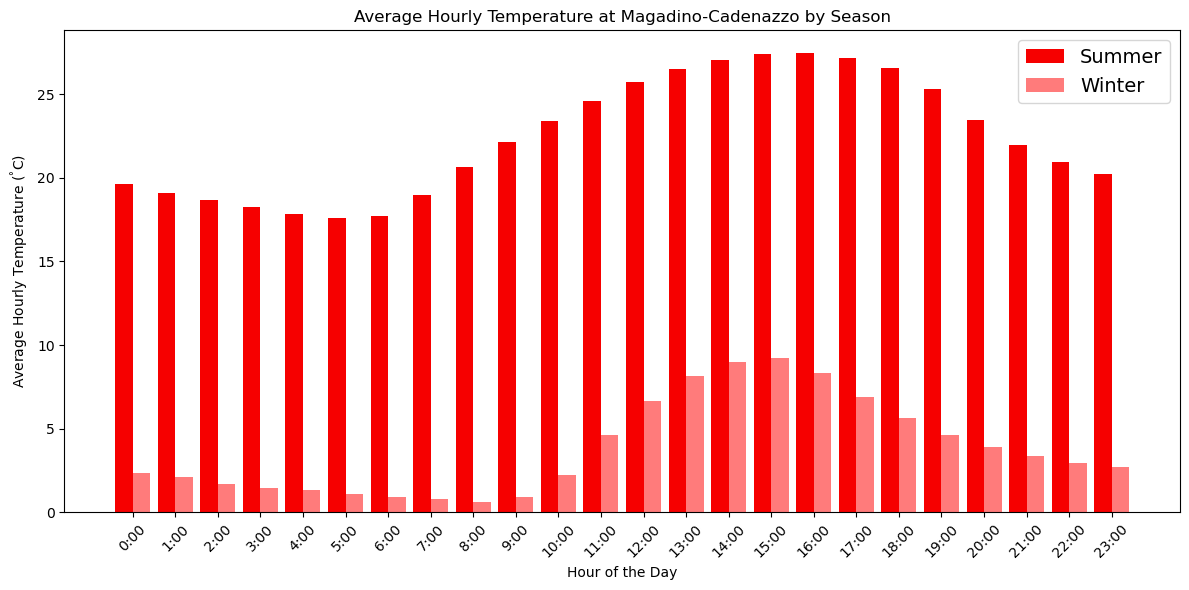

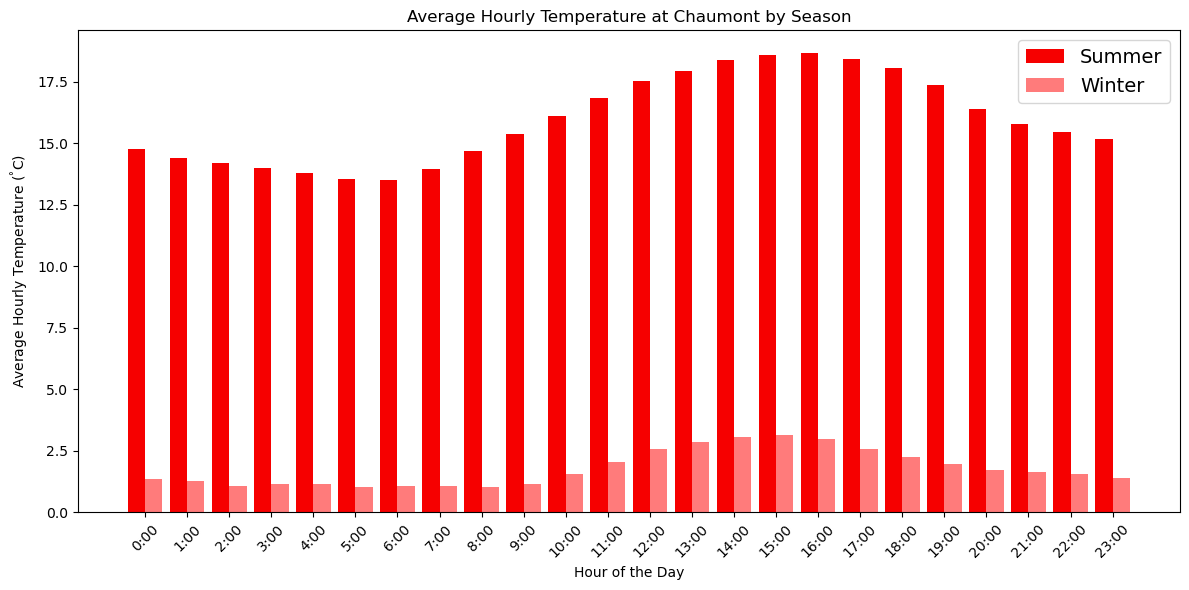

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import colorsys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

plt.rcParams['legend.fontsize'] = 14  # Sets the default legend font size to 14 points

# Extract the pollutant name from the filename
pollutant_name = Path(file_path).stem

# Step 1: Load the data
file_path = 'TEMP.csv'  # Replace with your actual file path
df = pd.read_csv(file_path, delimiter=';', parse_dates=['Date/heure'], dayfirst=True)
df.set_index('Date/heure', inplace=True)

# Step 2: Define seasons
# Assuming winter is from December to February and summer is from June to August
df['Season'] = np.where(df.index.month.isin([12, 1, 2]), 'Winter',
                        np.where(df.index.month.isin([6, 7, 8]), 'Summer', 'Other'))

# Step 3: Filter out only summer and winter data
df_seasonal = df[df['Season'] != 'Other']

# Step 4: Calculate hourly averages for each season and station
hourly_means = df_seasonal.groupby([df_seasonal.index.hour, 'Season']).mean().unstack()

# Step 5: Function to lighten a color
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by reducing its saturation and increasing its lightness.
    Input can be a matplotlib color string, hex string, or RGB tuple.
    """
    try:
        c = mcolors.cnames[color]
    except KeyError:
        c = color
    rgb = mcolors.to_rgb(c)
    hls = colorsys.rgb_to_hls(*rgb)
    lighter_rgb = colorsys.hls_to_rgb(hls[0], 1 - amount * (1 - hls[1]), hls[2])
    return lighter_rgb

# Step 6: Plotting
base_color = '#F60000'  # Default base color
lighter_color = lighten_color(base_color, 0.5)

for station in ['Magadino-Cadenazzo', 'Chaumont']:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Data for plotting
    indices = np.arange(24)
    summer_means = hourly_means[station]['Summer'].values
    winter_means = hourly_means[station]['Winter'].values
    
    # Bar width and spacing
    bar_width = 0.35
    spacing = 0.15
    total_width = 2 * bar_width + spacing
    positions = indices * total_width
    
    # Plot bars
    ax.bar(positions, summer_means, width=bar_width, color=base_color, label='Summer')
    ax.bar(positions + bar_width, winter_means, width=bar_width, color=lighter_color, label='Winter')
    
    # Formatting the plot
    ax.set_xlabel('Hour of the Day')
    ax.set_ylabel('Average Hourly Temperature ($^°$C)')
    ax.set_title(f'Average Hourly Temperature at {station} by Season')
    ax.set_xticks(positions + bar_width / 2)
    ax.set_xticklabels([f'{h}:00' for h in range(24)], rotation=45)
    ax.legend()
    
    plt.tight_layout()
    plt.show()